<a href="https://colab.research.google.com/github/respect5716/deep-learning-paper-implementation/blob/main/02_Vision/NeRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeRF

## 0. Info

### Paper
* title: NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis
* author: Ben Mildenhall et al
* url: https://arxiv.org/abs/2003.08934

### Features
* dataset: [llff](https://github.com/kwea123/nerf_pl)

### Reference
* https://github.com/bmild/nerf
* https://github.com/yenchenlin/nerf-pytorch
* https://github.com/kwea123/nerf_pl

## 1. Setup

In [21]:
!pip install -q kornia

     |████████████████████████████████| 493 kB 14.3 MB/s 


In [23]:
import os
import easydict
from glob import glob
from tqdm.auto import tqdm
from PIL import Image
from kornia import create_meshgrid
from IPython.display import Image as Img

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T

In [44]:
cfg = easydict.EasyDict(
    dataset = 'llff',
    scene = 'flower',

    img_wh = [504, 378],
    spheric = False,
    N_coarse = 64,
    N_fine = 64,
    perturb = 1.,
    alpha_noise_std = 1.,

    num_epoch = 5,
    batch_size = 1024,
    lr = 5e-4,

    device = 'cuda',
    dataset_dir = '/content/drive/Shareddrives/dataset',
)

SyntaxError: ignored

## 2. Data

### 2.1. Load

In [4]:
data_path = os.path.join(cfg.dataset_dir, f'{cfg.dataset}.zip')
!unzip -q "{data_path}" -d 'data'

### 2.2. Ray

In [5]:
# HELP: https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-generating-camera-rays
def get_ray_directions(H, W, focal):
    # 카메라 좌표계에서 ray의 방향 벡터
    grid = create_meshgrid(H, W, normalized_coordinates=False)[0] # (H, W, 2)
    i, j = grid.unbind(-1) # (H, W), (H, W)
    directions = torch.stack([(i - W/2) / focal, -(j - H/2) / focal, -torch.ones_like(i)], -1) # (H, W, 3)
    return directions


def get_rays(directions, c2w):
    # Get ray origin and normalized directions in world coordinate for all pixels in one image.
    rays_d = directions @ c2w[:, :3].T # 월드  좌표계에서 ray의 방향 벡터 (H, W, 3)
    rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True) # 
    rays_o = c2w[:, 3].expand(rays_d.shape) # 월드 좌표계에서 카메라의 위치 (H, W, 3)

    rays_d = rays_d.view(-1, 3) # (HxW, 3)
    rays_o = rays_o.view(-1, 3) # (HxW, 3)
    return rays_o, rays_d


def get_ndc_rays(H, W, focal, near, rays_o, rays_d):
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d

    ox_oz = rays_o[...,0] / rays_o[...,2]
    oy_oz = rays_o[...,1] / rays_o[...,2]
    
    o0 = -1./(W/(2.*focal)) * ox_oz
    o1 = -1./(H/(2.*focal)) * oy_oz
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - ox_oz)
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - oy_oz)
    d2 = 1 - o2
    
    rays_o = torch.stack([o0, o1, o2], -1) # (B, 3)
    rays_d = torch.stack([d0, d1, d2], -1) # (B, 3)
    
    return rays_o, rays_d

### 2.4. Preprocess

In [28]:
def normalize(v):
    return v / np.linalg.norm(v)


def average_poses(poses):
    center = poses[..., 3].mean(0) # (3)
    z = normalize(poses[..., 2].mean(0)) # (3)
    y_ = poses[..., 1].mean(0) # (3)
    x = normalize(np.cross(y_, z)) # (3)
    y = np.cross(z, x) # (3)
    pose_avg = np.stack([x, y, z, center], 1) # (3, 4)
    return pose_avg


def center_poses(poses):
    pose_avg = average_poses(poses) # (3, 4)
    pose_avg_homo = np.eye(4)
    pose_avg_homo[:3] = pose_avg # convert to homogeneous coordinate for faster computation
                                 # by simply adding 0, 0, 0, 1 as the last row
    last_row = np.tile(np.array([0, 0, 0, 1]), (len(poses), 1, 1)) # (N_images, 1, 4)
    poses_homo = np.concatenate([poses, last_row], 1) # (N_images, 4, 4) homogeneous coordinate

    poses_centered = np.linalg.inv(pose_avg_homo) @ poses_homo # (N_images, 4, 4)
    poses_centered = poses_centered[:, :3] # (N_images, 3, 4)
    return poses_centered, np.linalg.inv(pose_avg_homo)


def create_spiral_poses(radii, focus_depth, n_poses=120):
    poses_spiral = []
    for t in np.linspace(0, 4*np.pi, n_poses+1)[:-1]:
        center = np.array([np.cos(t), -np.sin(t), -np.sin(0.5*t)]) * radii
        z = normalize(center - np.array([0, 0, -focus_depth]))
        y_ = np.array([0, 1, 0]) # (3)
        x = normalize(np.cross(y_, z)) # (3)
        y = np.cross(z, x) # (3)
        poses_spiral += [np.stack([x, y, z, center], 1)] # (3, 4)

    return np.stack(poses_spiral, 0) # (n_poses, 3, 4)


def create_spheric_poses(radius, n_poses=120):
    def spheric_pose(theta, phi, radius):
        trans_t = lambda t : np.array([
            [1,0,0,0],
            [0,1,0,-0.9*t],
            [0,0,1,t],
            [0,0,0,1],
        ])

        rot_phi = lambda phi : np.array([
            [1,0,0,0],
            [0,np.cos(phi),-np.sin(phi),0],
            [0,np.sin(phi), np.cos(phi),0],
            [0,0,0,1],
        ])

        rot_theta = lambda th : np.array([
            [np.cos(th),0,-np.sin(th),0],
            [0,1,0,0],
            [np.sin(th),0, np.cos(th),0],
            [0,0,0,1],
        ])

        c2w = rot_theta(theta) @ rot_phi(phi) @ trans_t(radius)
        c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
        return c2w[:3]

    spheric_poses = []
    for th in np.linspace(0, 2*np.pi, n_poses+1)[:-1]:
        spheric_poses += [spheric_pose(th, -np.pi/5, radius)] # 36 degree view downwards
    return np.stack(spheric_poses, 0)


class LLFFDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='train', img_wh=(504, 378), spheric_poses=False, val_num=1):
        self.root_dir = root_dir
        self.split = split
        self.img_wh = img_wh
        self.spheric_poses = spheric_poses
        self.val_num = max(1, val_num) # at least 1
        self.transform = T.ToTensor()

        self.read_meta()
        self.white_back = False

    def read_meta(self):
        poses_bounds = np.load(f'{self.root_dir}/poses_bounds.npy') # (N_images, 17)
        self.image_paths = sorted(glob(f'{self.root_dir}/images/*'))
        poses = poses_bounds[:, :15].reshape(-1, 3, 5) # camera to world (Rotation 3X3, Translation 3X1, HWF 3X1) (N_images, 3, 5)
        self.bounds = poses_bounds[:, -2:] # depth (near, far) (N_images, 2)

        # Step 1: rescale focal length according to training resolution
        H, W, self.focal = poses[0, :, -1] # original intrinsics, same for all images
        assert H * self.img_wh[0] == W * self.img_wh[1], f'You must set @img_wh to have the same aspect ratio as ({W}, {H}) !'
        self.focal *= self.img_wh[0] / W

        # Step 2: correct poses
        # Original poses has rotation in form "down right back", change to "right up back"
        # See https://github.com/bmild/nerf/issues/34
        poses = np.concatenate([poses[..., 1:2], -poses[..., :1], poses[..., 2:4]], -1) # exclude H, W, focal (N_images, 3, 4) 
        self.poses, self.pose_avg = center_poses(poses)
        distances_from_center = np.linalg.norm(self.poses[..., 3], axis=1)
        val_idx = np.argmin(distances_from_center)
        
        # Step 3: correct scale so that the nearest depth is at a little more than 1.0
        # See https://github.com/bmild/nerf/issues/34
        near_original = self.bounds.min()
        scale_factor = near_original*0.75 
        self.bounds /= scale_factor
        self.poses[..., 3] /= scale_factor

        # ray directions for all pixels, same for all images (same H, W, focal)
        self.directions = get_ray_directions(self.img_wh[1], self.img_wh[0], self.focal) # (H, W, 3)
            
        if self.split == 'train':
            self.all_rays, self.all_rgbs = [], []
            for i, image_path in enumerate(self.image_paths):
                if i == val_idx: continue # exclude the val image
                c2w = torch.FloatTensor(self.poses[i])

                img = Image.open(image_path).convert('RGB')
                img = img.resize(self.img_wh, Image.LANCZOS)
                img = self.transform(img) # (3, h, w)
                img = img.view(3, -1).permute(1, 0) # (h*w, RGB)
                self.all_rgbs += [img]
                
                rays_o, rays_d = get_rays(self.directions, c2w) # both (h*w, 3)
                if self.spheric_poses:
                    near = self.bounds.min()
                    far = min(8 * near, self.bounds.max()) # focus on central object only
                else:
                    near, far = 0, 1
                    rays_o, rays_d = get_ndc_rays(self.img_wh[1], self.img_wh[0], self.focal, 1.0, rays_o, rays_d)

                near_vec = near * torch.ones_like(rays_o[:, :1])
                far_vec = far * torch.ones_like(rays_o[:, :1])
                self.all_rays += [torch.cat([rays_o, rays_d, near_vec, far_vec], dim=1)] # (h*w, 8)
                                 
            self.all_rays = torch.cat(self.all_rays, 0) # ((N_images-1)*h*w, 8)
            self.all_rgbs = torch.cat(self.all_rgbs, 0) # ((N_images-1)*h*w, 3)
        
        elif self.split == 'val':
            print('val image is', self.image_paths[val_idx])
            self.c2w_val = self.poses[val_idx]
            self.image_path_val = self.image_paths[val_idx]

        else:
            if self.split.endswith('train'): # test on training set
                self.poses_test = self.poses
                
            elif self.spheric_poses:
                radius = 1.1 * self.bounds.min()
                self.poses_test = create_spheric_poses(radius)
                
            else:
                focus_depth = 3.5
                radii = np.percentile(np.abs(self.poses[..., 3]), 90, axis=0)
                self.poses_test = create_spiral_poses(radii, focus_depth)


    def __len__(self):
        if self.split == 'train':
            return len(self.all_rays)
        if self.split == 'val':
            return self.val_num
        return len(self.poses_test)

    def __getitem__(self, idx):
        if self.split == 'train': # use data in the buffers
            sample = {'rays': self.all_rays[idx],
                      'rgbs': self.all_rgbs[idx]}
        else:
            if self.split == 'val':
                c2w = torch.FloatTensor(self.c2w_val)
            else:
                c2w = torch.FloatTensor(self.poses_test[idx])

            rays_o, rays_d = get_rays(self.directions, c2w)

            if self.spheric_poses:
                near = self.bounds.min()
                far = min(8 * near, self.bounds.max())
            else:
                near, far = 0, 1
                rays_o, rays_d = get_ndc_rays(self.img_wh[1], self.img_wh[0], self.focal, 1.0, rays_o, rays_d)
            
            near_vec = near * torch.ones_like(rays_o[:, :1])
            far_vec = far * torch.ones_like(rays_o[:, :1])
            rays = torch.cat([rays_o, rays_d, near_vec, far_vec], 1)

            sample = {'rays': rays, 'c2w': c2w}
            if self.split == 'val':
                img = Image.open(self.image_path_val).convert('RGB')
                img = img.resize(self.img_wh, Image.LANCZOS)
                img = self.transform(img) # (3, h, w)
                img = img.view(3, -1).permute(1, 0) # (h*w, 3)
                sample['rgbs'] = img

        return sample

## 3. Model

In [29]:
class PositionalEncoder(nn.Module):
    def __init__(self, num_freq, logscale=True, include_input=True):
        super().__init__()
        self.num_freq = num_freq
        self.include_input = include_input
        
        self.funcs = [torch.sin, torch.cos]
        if logscale:
            self.freq_bands = 2 ** torch.linspace(start=0, end=num_freq-1, steps=num_freq)
        else:
            self.freq_bands = torch.linspace(start=2.**0, end=2.**(num_freq-1), steps=num_freq)
                
    def forward(self, x):
        out = []
        if self.include_input:
            out.append(x)
            
        for freq in self.freq_bands:
            for fn in self.funcs:
                out.append(fn(freq * x))
        
        return torch.cat(out, dim=-1)
    
    
class NeRF(nn.Module):
    def __init__(self, num_layer=8, dim=256, skips=[4], pos_num_freq=10, dir_num_freq=4):
        super().__init__()
        self.skips = skips
        self.pos_pe = PositionalEncoder(pos_num_freq)
        self.dir_pe = PositionalEncoder(dir_num_freq)
        
        pos_infeats = 3 * (pos_num_freq * 2 + 1)
        dir_infeats = 3 * (dir_num_freq * 2 + 1)
        self.pos_net = nn.ModuleList()
        for i in range(num_layer):
            if i == 0:
                self.pos_net.append(nn.Linear(pos_infeats, dim))
            elif i in skips:
                self.pos_net.append(nn.Linear(dim+pos_infeats, dim))
            else:
                self.pos_net.append(nn.Linear(dim, dim))
        self.dir_net = nn.Linear(dim+dir_infeats, dim//2)
        
        self.sigma = nn.Linear(dim, 1)
        self.rgb = nn.Sequential(
            nn.Linear(dim//2, 3),
            nn.Sigmoid()
        )
        
        
    def forward(self, pos_x, dir_x=None):
        pos_x = self.pos_pe(pos_x)        
        pos_h = pos_x
        for i, layer in enumerate(self.pos_net):
            if i in self.skips:
                pos_h = torch.cat([pos_h, pos_x], dim=-1)
            pos_h = F.relu(layer(pos_h))
            
        sigma = self.sigma(pos_h)
        rgb = None

        if dir_x is not None:
            dir_x = self.dir_pe(dir_x)
            dir_h = torch.cat([pos_h, dir_x], dim=-1)
            dir_h = F.relu(self.dir_net(dir_h))
            rgb = self.rgb(dir_h)
        
        return {'rgb': rgb, 'sigma': sigma}

In [30]:
def sample_z(N_sample, perturb, near, far):
    # Sample depth points
    z_steps = torch.linspace(0, 1, N_sample, device=near.device)
    z_vals = near * (1-z_steps) + far * z_steps
    z_vals = z_vals.expand(near.size(0), N_sample) # (N_ray, N_sample)
    
    if perturb > 0.:
        z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:]) # (N_ray, N_sample-1) interval mid points
        upper = torch.cat([z_vals_mid, z_vals[: ,-1:]], -1)
        lower = torch.cat([z_vals[: ,:1], z_vals_mid], -1)
        
        perturb_rand = perturb * torch.rand(z_vals.shape, device=rays.device)
        z_vals = lower + (upper - lower) * perturb_rand
    
    return z_vals


def inference(model, points, directions, z_vals, alpha_noise_std, chunk_size):
    # prepare
    device = next(model.parameters()).device
    N_ray, N_sample, N_channel = points.size()
    B = N_ray * N_sample
    points = points.view(B, -1)
    directions = directions.repeat(1, N_sample, 1).view(B, -1)
    
    # predict sigmas and rgbs
    outputs = []
    for i in range(0, B, chunk_size):
        p = points[i:i+chunk_size].to(device)
        d = directions[i:i+chunk_size].to(device)
        outputs.append(model(p, d))
        
    sigmas = torch.cat([o['sigma'] for o in outputs], dim=0)
    rgbs = torch.cat([o['rgb'] for o in outputs], dim=0)
    sigmas = sigmas.squeeze().view(N_ray, N_sample)
    rgbs = rgbs.view(N_ray, N_sample, 3)
    
    # compute delta
    deltas = z_vals[:, 1:] - z_vals[:, :-1] # (N_ray, N_sample-1)
    delta_inf = 1e10 * torch.ones_like(deltas[:, :1]) # the last delta is infinity (N_ray, 1) 
    deltas = torch.cat([deltas, delta_inf], -1)  # (N_ray, N_sample)
    deltas = deltas.to(device)

    # compute alphas
    noise = torch.randn_like(sigmas) * alpha_noise_std # (N_ray, N_sample)
    sigmas = F.relu(sigmas + noise) # (N_ray, N_sample)
    alphas = 1 - torch.exp(-deltas * sigmas) # 0 ~ 1 (N_ray, N_sample)
    
    # compute weights
    alphas_shifted = torch.cat([torch.ones_like(alphas[:,:1]), 1 - alphas[:,:-1] + 1e-10], dim=-1) # (N_ray, N_sample)
    Ts = torch.cumprod(alphas_shifted, -1) # T_i = (1 - a_1) ... (1-a_{i-1}) (N_ray, N_sample)
    weights = Ts * alphas
    opacity = weights.sum(dim=1)

    # compute final results
    rgbs_final = torch.sum(weights.unsqueeze(dim=2) * rgbs, dim=1) # (N_ray, 3)
    depths_final = torch.sum(weights * z_vals, dim=-1) # (N_ray)
    return rgbs_final, depths_final, weights


def sample_pdf(z_vals, weights, N_importance, deterministic=False, eps=1e-5):
    # prepare
    bins = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:]) # (N_ray, N_sample-1) interval mid points
    weights = weights[:, 1:-1].detach()
    N_ray, N_sample_ = weights.shape # (N_ray, N_sample-2)
    weights = weights + eps # prevent division by zero (don't do inplace op!)
    
    # compute pdf and cdf from weights
    pdf = weights / torch.sum(weights, -1, keepdim=True) # (N_ray, N_sample-2)
    cdf = torch.cumsum(pdf, -1) # cumulative distribution function (N_ray, N_sample-2)
    cdf = torch.cat([torch.zeros_like(cdf[: ,:1]), cdf], -1) # insert zero (N_rays, N_samples-1)
    cdf = cdf.to(bins.device)
    
    # sample from uniform
    if deterministic:
        u = torch.linspace(0, 1, N_importance, device=bins.device) # (N_importance)
        u = u.expand(N_ray, N_importance) # (N_ray, N_importance)
    else:
        u = torch.rand(N_ray, N_importance, device=bins.device)
    u = u.contiguous()
    
    # get index of samples from cdf
    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.clamp_min(inds-1, 0) # (N_ray)
    above = torch.clamp_max(inds, N_sample_)
    
    inds_g = torch.stack([below, above], -1).view(N_ray, 2*N_importance)
    cdf_g = torch.gather(cdf, 1, inds_g).view(N_ray, N_importance, 2)
    bins_g = torch.gather(bins, 1, inds_g).view(N_ray, N_importance, 2)
    
    # inverse cdf method
    # https://dk81.github.io/dkmathstats_site/prob-inverse-cdf.html
    denom = cdf_g[...,1] - cdf_g[...,0] # height (N_ray, N_importance) (diff between above and below)
    denom[denom < eps] = 1

    U = (u - cdf_g[..., 0]) / denom
    samples = bins_g[..., 0] + U * (bins_g[..., 1]-bins_g[..., 0])
    return samples


def render(
    coarse_model, 
    fine_model, 
    rays, 
    N_coarse, 
    N_fine, 
    perturb, 
    alpha_noise_std,
    chunk_size = 4096
):
    rays_o, rays_d, near, far = rays[:, 0:3], rays[:, 3:6], rays[:, 6:7], rays[:, 7:8]
    rays_o = rays_o.unsqueeze(dim=1) # (batch, 1, 3)
    rays_d = rays_d.unsqueeze(dim=1) # (batch, 1, 3)
    
    z_vals_coarse = sample_z(N_coarse, perturb, near, far)
    points_coarse = rays_o + rays_d * z_vals_coarse.unsqueeze(dim=2)
    rgbs_coarse, depths_coarse, weights_coarse = inference(
        coarse_model, points_coarse, rays_d, z_vals_coarse, alpha_noise_std, chunk_size=chunk_size
    )
    
    z_vals_fine = sample_pdf(z_vals_coarse, weights_coarse, N_fine)
    z_vals_fine = torch.sort(torch.cat([z_vals_coarse, z_vals_fine], dim=-1), dim=-1)[0] # (N_rays, N_coarse + N_fine)
    points_fine = rays_o + rays_d * z_vals_fine.unsqueeze(dim=2)
    rgbs_fine, depths_fine, weights_fine = inference(
        fine_model, points_fine, rays_d, z_vals_fine, alpha_noise_std, chunk_size=chunk_size
    )
    
    return {'rgbs_coarse': rgbs_coarse, 'rgbs_fine': rgbs_fine}

## 4. Utils

In [37]:
def mse(image_pred, image_gt, valid_mask=None, reduction='mean'):
    value = (image_pred-image_gt)**2
    if valid_mask is not None:
        value = value[valid_mask]
    if reduction == 'mean':
        return torch.mean(value)
    return value

def psnr_metric(image_pred, image_gt, valid_mask=None, reduction='mean'):
    return -10*torch.log10(mse(image_pred, image_gt, valid_mask, reduction))

def draw_image(tensors, H, W):
    img = tensors.cpu().view(H, W, 3).permute(2, 0, 1)
    return T.ToPILImage()(img)

## 5. Train

In [33]:
train_ds = LLFFDataset(f'data/nerf_llff_data/{cfg.scene}', split='train', img_wh=cfg.img_wh, spheric_poses=cfg.spheric, val_num=1)
valid_ds = LLFFDataset(f'data/nerf_llff_data/{cfg.scene}', split='val', img_wh=cfg.img_wh, spheric_poses=cfg.spheric, val_num=1)

val image is data/nerf_llff_data/flower/images/IMG_2982.JPG


In [34]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False)

In [36]:
coarse_model = NeRF().to(cfg.device)
fine_model = NeRF().to(cfg.device)

params = list(fine_model.parameters()) + list(coarse_model.parameters())
optimizer = torch.optim.Adam(params, lr=cfg.lr, eps=1e-8, weight_decay=0, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.5)

In [38]:
for ep in range(cfg.num_epoch):
    pbar = tqdm(train_loader)
    for batch in pbar:
        rays, rgbs = batch['rays'], batch['rgbs']
        rays, rgbs = rays.to(cfg.device), rgbs.to(cfg.device)
        results = render(
            coarse_model, fine_model, rays, 
            N_coarse = cfg.N_coarse, N_fine = cfg.N_fine, 
            perturb = cfg.perturb, alpha_noise_std = cfg.alpha_noise_std
        )
        loss = F.mse_loss(results['rgbs_coarse'], rgbs) + F.mse_loss(results['rgbs_fine'], rgbs)
        with torch.no_grad():
            psnr = psnr_metric(results[f'rgbs_fine'], rgbs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item(), 'psnr': psnr.item()})
    
    scheduler.step()
    torch.save(coarse_model.state_dict(), 'coarse.pth')
    torch.save(fine_model.state_dict(), 'fine.pth')

  0%|          | 0/6140 [00:00<?, ?it/s]

  0%|          | 0/6140 [00:00<?, ?it/s]

  0%|          | 0/6140 [00:00<?, ?it/s]

  0%|          | 0/6140 [00:00<?, ?it/s]

  0%|          | 0/6140 [00:00<?, ?it/s]

## 5. Test

### 5.1. Validate

In [39]:
coarse_model = NeRF()
fine_mode = NeRF()

coarse_model.load_state_dict(torch.load('coarse.pth'))
fine_model.load_state_dict(torch.load('fine.pth'))

_ = coarse_model.eval().to(cfg.device)
_ = fine_model.eval().to(cfg.device)

In [40]:
for batch in valid_loader:
    rays, rgbs = batch['rays'].squeeze(), batch['rgbs'].squeeze()
    rays, rgbs = rays.to(cfg.device), rgbs.to(cfg.device)
    with torch.no_grad():
        results = render(
            coarse_model, fine_model, rays, 
            N_coarse = cfg.N_coarse, N_fine = cfg.N_fine, 
            perturb = 0., alpha_noise_std = 0.,
        )

loss = F.mse_loss(results['rgbs_fine'], rgbs).item()
psnr = psnr_metric(results[f'rgbs_fine'], rgbs).item()

print(f'loss: {loss:.3f} | psnr: {psnr:.3f}')

loss: 0.002 | psnr: 26.546


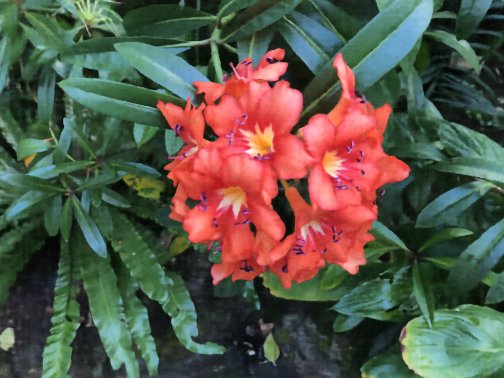

In [41]:
# predicted
draw_image(results['rgbs_fine'], cfg.img_wh[1], cfg.img_wh[0])

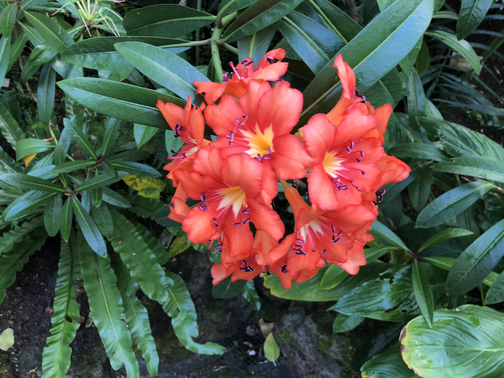

In [42]:
# real
draw_image(rgbs, cfg.img_wh[1], cfg.img_wh[0])

### 5.2. Video rendering

In [45]:
test_ds = LLFFDataset(f'data/nerf_llff_data/{cfg.scene}', split='test', img_wh=cfg.img_wh, spheric_poses=cfg.spheric)

In [46]:
images = []
for i in tqdm(range(len(test_ds))):
    sample = test_ds[i]
    rays = sample['rays'].to(cfg.device)
    with torch.no_grad():
        results = render(
            coarse_model, fine_model, rays,
            N_coarse = cfg.N_coarse, N_fine = cfg.N_fine, 
            perturb = 0., alpha_noise_std = 0.,
        )
    img = draw_image(results['rgbs_fine'], cfg.img_wh[1], cfg.img_wh[0])
    images.append(img)
    
images[0].save(f'{cfg.scene}.gif', save_all=True, append_images=images[1:])

  0%|          | 0/120 [00:00<?, ?it/s]

In [49]:
Img(url=f'{cfg.scene}.gif')